In [1]:
import sys
import ssl
import urllib.request
from io import StringIO

from copy import deepcopy
import os
from os import getcwd
from os.path import dirname, join
from sklearn.neighbors import KNeighborsRegressor
from scipy.optimize import minimize, basinhopping


import datetime
from sklearn import preprocessing



import csv
import json

# Load Json File
# Load the arguments
with open('arguments.json', 'r') as fid:
    arguments = json.load(fid)




import matplotlib.pyplot as plt
import numpy as np
import scipy 
import pandas as pd
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

SRC_DIR = '../../mammal/MAMMAL' # relative path to MAMMAL library 
sys.path.append(SRC_DIR)
BASE_DIR = getcwd() # get current directory with files
DATA_DIR = join(BASE_DIR, arguments['data_dir'])
TEST_DIR = join(DATA_DIR, 'test') # directory with intermagnet data
EXAM_DIR = join(DATA_DIR, 'diurnal_test_data') # second day intermagnet data to test parameters

import Diurnal
from Parse import parseIM as pi
from Utils import ProcessingUtils as pu
from Utils import Filters as filt

# Create Output CSV File
out_file = open(arguments['csv_file'], mode = 'a', encoding='UTF8')

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)#

# Determine Day Ranges for Training and Testing Data Sets

In [2]:
obj = os.walk(TEST_DIR)
date_names = []
file_names = []
for _, _, files in obj:
    for file in files:
        if(file[16:] == 'min'):
            file_names.append(file[3:11])

x = sorted(file_names)
#print(x)
start_tra = x[0]
end_tra = x[len(x)-1]

# Do It again for Testing Data 
obj = os.walk(EXAM_DIR)
date_names = []
file_names = []
for _, _, files in obj:
    for file in files:
        if(file[16:] == 'min'):
            file_names.append(file[3:11])

x = sorted(file_names)
#print(x)
start_tst = x[0]
end_tst = x[len(x)-1]

# Load INTERMAGNET Data

/home/antuser/anaconda3/envs/envp39/lib/python3.9/site-packages/pandas-1.3.4-py3.9-linux-x86_64.egg/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Loaded bou20220821dmin.min
Loaded frd20220821dmin.min
Loaded frd20220818dmin.min
Loaded bou20220818dmin.min
Loaded frd20220826dmin.min
Loaded bou20220826dmin.min
Loaded bou20220827dmin.min
Loaded frd20220827dmin.min
Loaded bou20220824dmin.min
Loaded frd20220824dmin.min
Loaded frd20220820dmin.min
Loaded bou20220820dmin.min
Loaded bou20220825dmin.min
Loaded frd20220825dmin.min
Loaded frd20220823dmin.min
Loaded bou20220823dmin.min
Loaded frd20220819dmin.min
Loaded bou20220819dmin.min
Loaded bou20220822dmin.min
Loaded frd20220822dmin.min


100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 140.32it/s]


            DATE     TIME  DOY        X       Y        Z         F  \
0     2022-08-18      0.0  230  20487.8  2905.2  47176.8  51514.84   
1     2022-08-18     60.0  230  20488.3  2904.6  47176.6  51514.82   
2     2022-08-18    120.0  230  20488.9  2904.6  47176.4  51514.78   
3     2022-08-18    180.0  230  20489.0  2904.6  47176.2  51514.73   
4     2022-08-18    240.0  230  20488.9  2905.3  47176.0  51514.45   
...          ...      ...  ...      ...     ...      ...       ...   
1435  2022-08-27  86100.0  239  20518.4  2911.7  47166.2  51518.58   
1436  2022-08-27  86160.0  239  20519.5  2912.0  47166.3  51519.03   
1437  2022-08-27  86220.0  239  20519.3  2912.1  47166.5  51519.24   
1438  2022-08-27  86280.0  239  20518.6  2912.2  47166.6  51518.95   
1439  2022-08-27  86340.0  239  20519.1  2912.4  47166.5  51519.17   

                datetime     epoch_sec    LAT     LONG     ALT        IGRF_X  \
0    2022-08-18 00:00:00  1.660781e+09  40.14 -105.241  1682.0  20531.921768   

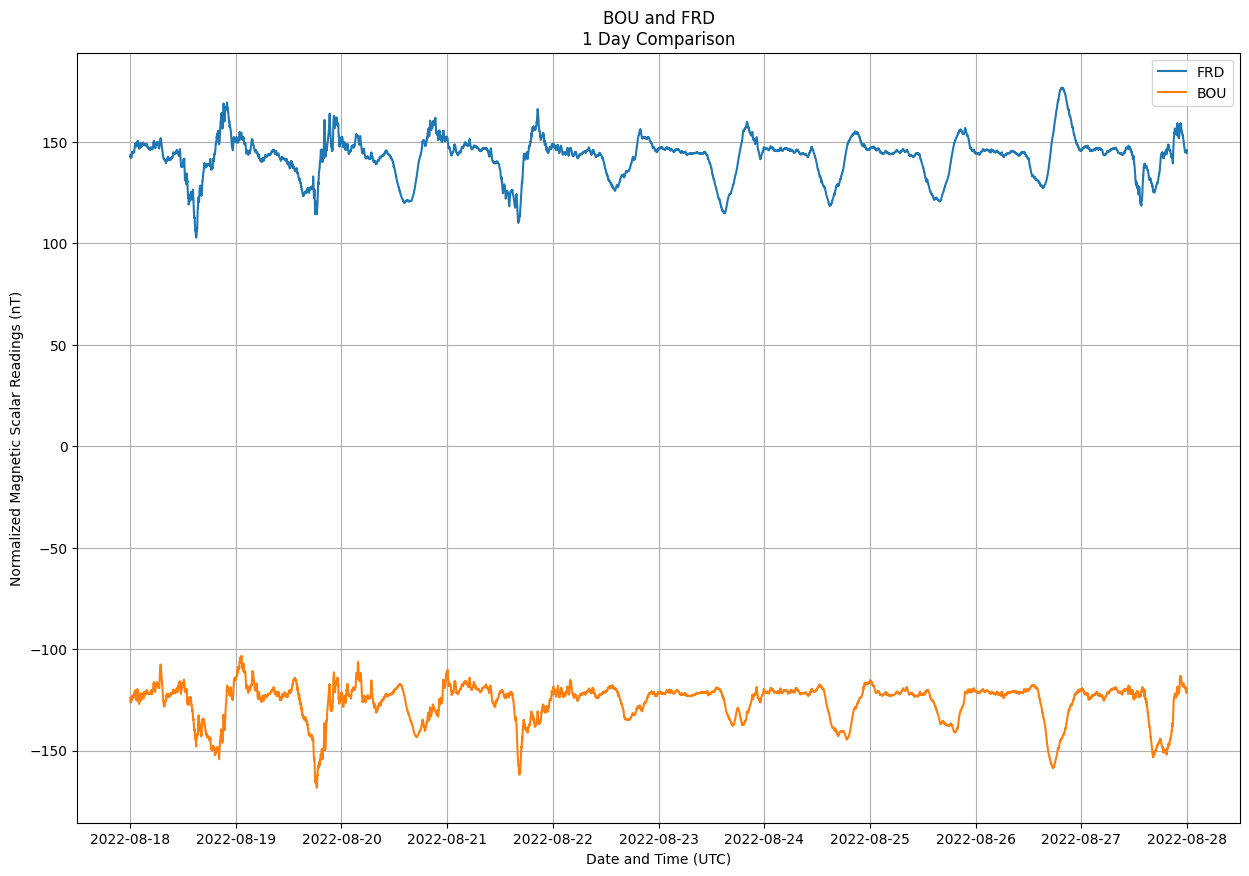

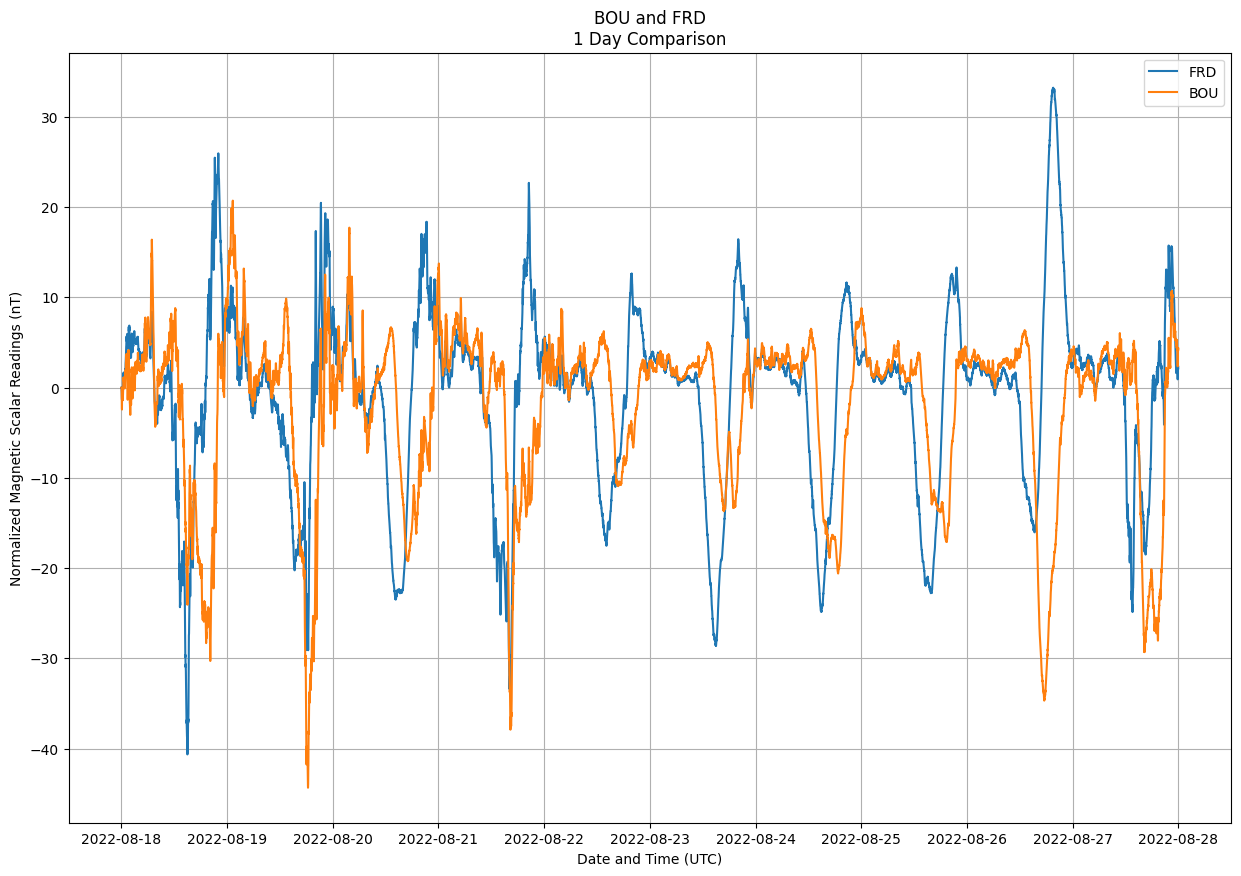

In [3]:
df_dict = pi.loadInterMagData(TEST_DIR, fast_mode = False, second = False)

from_name = arguments['from_data'] # data from 'extended' station
to_name   = arguments['to_data'] # data at location to estimate

from_df = df_dict[from_name]
to_df   = df_dict[to_name]


to_df = pu.reject_outliers(to_df,
                           window_size=200,
                           std_lim=3)

print(from_df)
to_IGRF_f   = np.array(to_df.IGRF_F)[0]
from_IGRF_f = np.array(from_df.IGRF_F)[0]

to_f   = np.array(to_df.F)
from_f = np.array(from_df.F)
    
to_f_no_core   = np.array(to_df.F) - to_IGRF_f
from_f_no_core = np.array(from_df.F) - from_IGRF_f
    
to_t   = np.array(to_df.epoch_sec)
from_t = np.array(from_df.epoch_sec)

plt.figure()
plt.title(from_name + ' and ' + to_name + '\n1 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime, from_f_no_core, label=from_name)
plt.legend()
plt.grid()
    
plt.figure()
plt.title(from_name + ' and ' + to_name + '\n1 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core - to_f_no_core[0], label=to_name)
plt.plot(from_df.datetime, from_f_no_core - from_f_no_core[0], label=from_name)
plt.legend()
plt.grid()

# print('RMSE:', pu.rmse(to_f_no_core, from_f_no_core[:len(to_f)])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers
# print('RMSE:', pu.rmse(to_f_no_core - to_f_no_core[0], from_f_no_core[:len(to_f)] - from_f_no_core[0])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers

# Simple Longitude Normalization

RMSE: 268.79828011301043


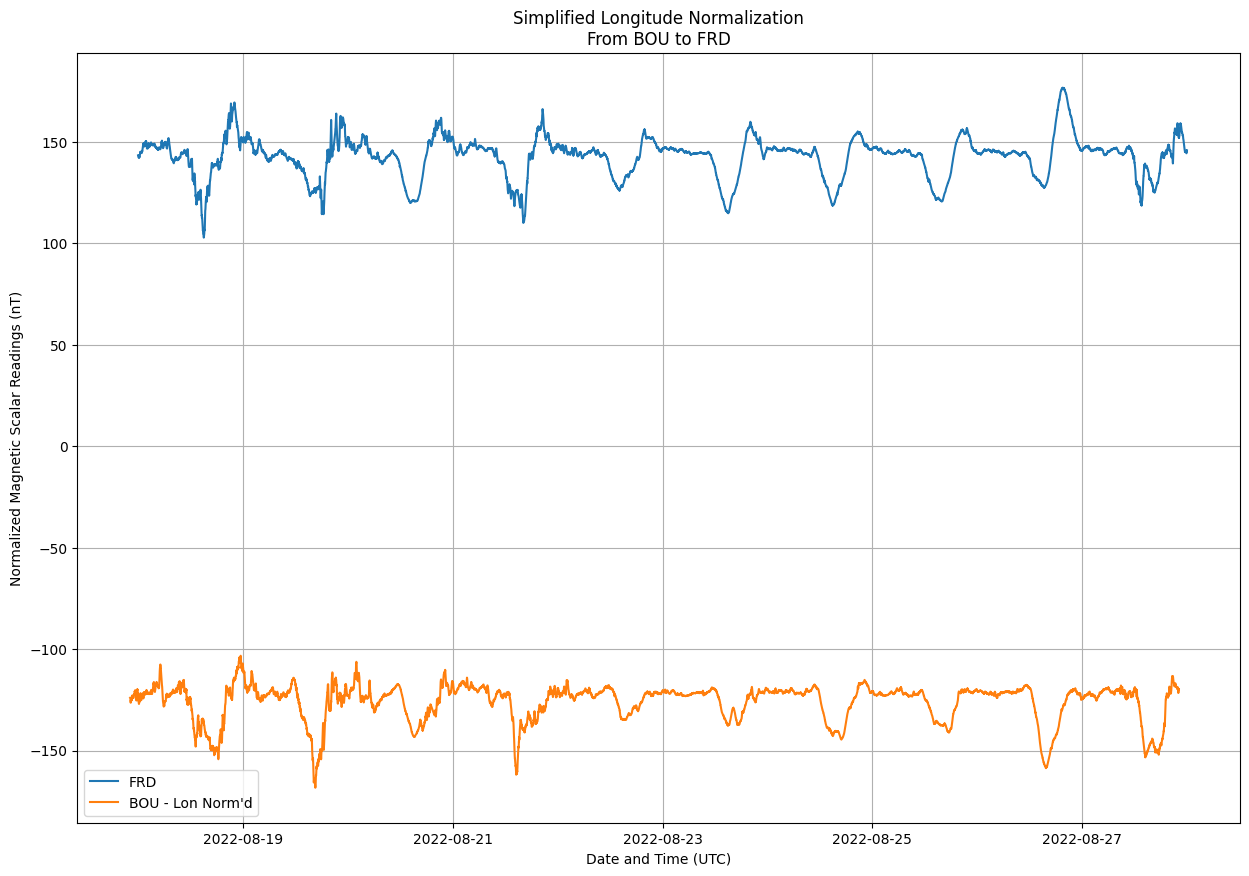

In [4]:
lon_diff     = from_df.LONG.mean() - to_df.LONG.mean()
lon_t_offset = pd.Timedelta(seconds=lon_diff / (Diurnal.E_ROT_DEG_S))
bou_shift_t  = from_df.epoch_sec + lon_t_offset.total_seconds()

plt.figure()
plt.title('Simplified Longitude Normalization\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime + lon_t_offset, from_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

interp_lpf = interpolate.interp1d(bou_shift_t, from_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= bou_shift_t.min(), to_t <= bou_shift_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

bou_shift_interp = interp_lpf(interp_t)

print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
                       bou_shift_interp))

# Frequency-Based Longitude Normalization

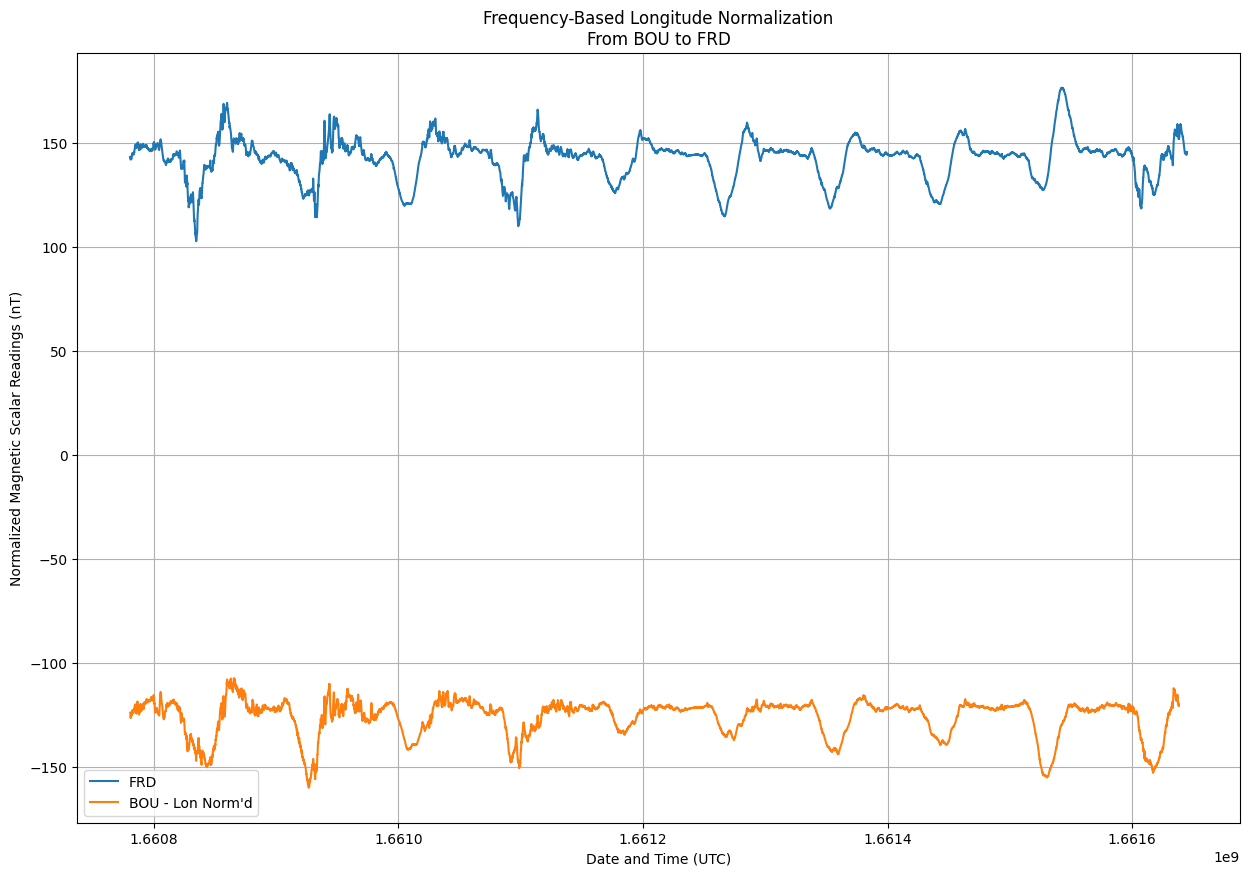

In [5]:
from_combined_t, from_combined_f, _, _ , _ = Diurnal.longitude_norm(from_df, to_df.LONG.mean(), second = False)
from_combined_f_no_core = from_combined_f - from_IGRF_f

plt.figure()
plt.title('Frequency-Based Longitude Normalization\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec, to_f_no_core, label=to_name)
plt.plot(from_combined_t, from_combined_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

# print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
#                        from_combined_f_no_core[:len(to_f_no_core[interp_mask])]))

# Neural Network Approach

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler

# create models

class ERSM_NN(nn.Module):
    __scaler = StandardScaler() # create scaler
    
    def __init__(self, n_hidden=4, d_in=4, d_out=1, d_hidden=50, drop_per=0.5, batch_size=1000):
        super(ERSM_NN, self).__init__()
        
        linear_ReLU_layers = []
        
        linear_ReLU_layers.append(nn.Linear(d_in, d_hidden))
        linear_ReLU_layers.append(nn.BatchNorm1d(d_hidden))
        linear_ReLU_layers.append(nn.Dropout(drop_per))
            
        for i in range(1,n_hidden):
            linear_ReLU_layers.append(nn.ReLU())
            linear_ReLU_layers.append(nn.Linear(d_hidden,d_hidden))
            linear_ReLU_layers.append(nn.BatchNorm1d(d_hidden))
            
        # Add Output Layer
        linear_ReLU_layers.append(nn.ReLU())
        linear_ReLU_layers.append(nn.Linear(d_hidden, int(d_hidden/10)))
        linear_ReLU_layers.append(nn.BatchNorm1d(int(d_hidden/10)))
        linear_ReLU_layers.append(nn.ReLU())
        linear_ReLU_layers.append(nn.Linear(int(d_hidden/10),d_out))
        
        # Convert List of Layers to Compatible Type
        self.layers = torch.nn.ModuleList(linear_ReLU_layers)
        
        self.__batch_size = batch_size
        
        self.double() # dtype

    
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
            
        return x
    
    def process_training_data(self, time, from_mag, to_mag, augment=False, bootstrap = True, num_augment = 10000):
        time_data = np.fmod(time, 24*3600)
        from_data = from_mag
        to_data = to_mag
        derivative_data = self.time_derivative(from_mag, time)
                 
        ## Get KP Data
        start_date, end_date = self.get_start_end_date(time)
        kp_df = self.get_KP_data(start_date, end_date)
        kp_data= map_kp_data(time, kp_df, quiet=True)
                 
        data_set = np.vstack((time_data, kp_data, derivative_data, from_data)).T
        
        if augment or bootstrap:
            bootstrap_indices = np.random.randint(data_set.shape[0], size = num_augment)
            Xtr_augment = np.empty((0,data_set.shape[1]))
            ytr_augment = np.empty((0,1))
            if augment:
                Xtr_augment = np.copy(data_set)
                ytr_augment = np.copy(np.vstack(to_data))

            for i in bootstrap_indices:
                new_sample = np.random.normal(loc=data_set[i,:], scale=0.002)
                Xtr_augment = np.append(Xtr_augment, [new_sample], axis = 0)
                ytr_augment = np.append(ytr_augment, to_data[i])
            data_set = Xtr_augment
            to_data = ytr_augment
        
        
        
        self.__Xtr = torch.tensor(self.__scaler.fit_transform(data_set), dtype=torch.float64)
        self.__ytr = torch.tensor(np.vstack((to_data)), dtype=torch.float64)
        print(self.__Xtr.dtype)
        print(self.__Xtr.shape, self.__ytr.shape)
        train_ds = torch.utils.data.TensorDataset(self.__Xtr, self.__ytr)
        self.__train_loader = torch.utils.data.DataLoader(train_ds,batch_size=self.__batch_size, shuffle = True) 
        return self.__train_loader, train_ds, self.__Xtr, self.__ytr
                 
    def process_testing_data(self, time, from_mag, to_mag):
        time_data = np.fmod(time, 24*3600)
        from_data = from_mag
        to_data = to_mag
        derivative_data = self.time_derivative(from_mag, time)
                 
        ## Get KP Data
        start_date, end_date = self.get_start_end_date(time)
        kp_df = self.get_KP_data(start_date, end_date)
        kp_data= map_kp_data(time, kp_df, quiet=True)
                 
        data_set = np.vstack((time_data, kp_data, derivative_data, from_data)).T
        
        self.__Xts = torch.tensor(self.__scaler.transform(data_set), dtype=torch.float64)
        self.__yts = torch.tensor(np.vstack((to_mag)), dtype=torch.float64)
        test_ds = torch.utils.data.TensorDataset(self.__Xts, self.__yts)
        self.__test_loader = torch.utils.data.DataLoader(test_ds,batch_size=self.__batch_size) 
        return self.__test_loader, test_ds, self.__Xts, self.__yts
    
    def x_tensor(self, time, from_mag):
        time_data = np.fmod(time, 24*3600)
        from_data = from_mag
        derivative_data = self.time_derivative(from_mag, time)
                 
        ## Get KP Data
        start_date, end_date = self.get_start_end_date(time)
        kp_df = self.get_KP_data(start_date, end_date)
        kp_data= map_kp_data(time, kp_df, quiet=True)
                 
        data_set = np.vstack((time_data, kp_data, derivative_data, from_data)).T
        
        Xts = torch.tensor(self.__scaler.transform(data_set), dtype=torch.float64)
        return Xts
            
                 
    def get_KP_data(self, start_date, end_date):
        df = pd.DataFrame()
        link = 'https://kp.gfz-potsdam.de/kpdata?startdate=' + start_date + '&enddate=' + end_date + '&format=kp2#kpdatadownload-143'

        ctx = ssl.create_default_context()
        ctx.check_hostname = False
        ctx.verify_mode = ssl.CERT_NONE
        data = StringIO(urllib.request.urlopen(link, context=ctx).read().decode('utf-8'))


        df[['Year', 'Month', 'Day', 'Start-Time', 'Mid-Time', 'Days_Since_Start_UT_Day', 'Days_Since_Mid_UT_Day', 'Kp', 'ap', 'Definitive']] = pd.read_csv(data, sep ="\s+") 

        y_arr = list(df['Year'])
        m_arr = list(df['Month'])
        d_arr = list(df['Day'])

        num_points = len(y_arr)

        hour_float_arr = list(df['Start-Time'])
        h_arr = list(map(int,hour_float_arr))

        min_float_arr = [(hour_float_arr[i] - h_arr[i])*60 for i in range(num_points)]
        min_arr = list(map(int, min_float_arr))

        sec_float_arr = [(min_float_arr[i] - min_arr[i])*60 for i in range(num_points)]
        sec_arr = list(map(int, sec_float_arr))

        num_points = len(y_arr)
        datetime_arr = [datetime.datetime(y_arr[i],m_arr[i],d_arr[i],h_arr[i],min_arr[i],sec_arr[i],0) for i in range(num_points)]


        df['datetime'] = datetime_arr
        df['epoch_sec'] = (df['datetime'] - pd.Timestamp('1970-01-01')).dt.total_seconds()

        return df


    def map_kp_data(self, time_series, kp_df, quiet = True):
        time_to_kp = interpolate.interp1d(list(kp_df['epoch_sec']),list(kp_df['Kp']),kind='previous')
        kp_array = time_to_kp(time_series)

        if quiet == False:
            return kp_array

        num_points = len(kp_array)
        mag_storm_thresh = 4
        kp_bool = np.empty(num_points, dtype='bool')

        for i in range(num_points):
            kp_bool[i] = ~(kp_array[i] >= mag_storm_thresh)

        # convert bool to float 
        return kp_bool.astype(float)
    


    def get_start_end_date(self, time):
        min_date = datetime.datetime.fromtimestamp(min(time))
        min_date -= datetime.timedelta(days=1)
        max_date = datetime.datetime.fromtimestamp(max(time))
        max_date += datetime.timedelta(days=1)

        min_date_str = min_date.strftime('%Y-%m-%d')
        max_date_str = max_date.strftime('%Y-%m-%d')

        return min_date_str, max_date_str

    def time_derivative(self, mag_array, time_array):
        n = len(mag_array)
        dxdt = []
        # Handle First Point With Forward Approximator
        dxdt.append((mag_array[1]-mag_array[0])/(time_array[1]-time_array[0]))

        # Handle Middle Points with Centered Approximator
        i = 1
        while i < n-1:
            dxdt.append((mag_array[i+1] - mag_array[i-1])/(time_array[i+1] - time_array[i-1]))
            i += 1

        # Handle Last Point  With Backward Approximator
        dxdt.append((mag_array[i]-mag_array[i-1])/(time_array[i]-time_array[i-1]))
        return np.array(dxdt)

# Utility Methods

In [7]:
def down_sample(array, fs=1/60):
    array_fft = np.fft.rfft(array)[0:int(len(array)*fs)]*(2*fs)
    return np.fft.irfft(array_fft) 

def get_KP_data(start_date, end_date):
    df = pd.DataFrame()
    link = 'https://kp.gfz-potsdam.de/kpdata?startdate=' + start_date + '&enddate=' + end_date + '&format=kp2#kpdatadownload-143'

    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE
    data = StringIO(urllib.request.urlopen(link, context=ctx).read().decode('utf-8'))


    df[['Year', 'Month', 'Day', 'Start-Time', 'Mid-Time', 'Days_Since_Start_UT_Day', 'Days_Since_Mid_UT_Day', 'Kp', 'ap', 'Definitive']] = pd.read_csv(data, sep ="\s+") 

    y_arr = list(df['Year'])
    m_arr = list(df['Month'])
    d_arr = list(df['Day'])

    num_points = len(y_arr)

    hour_float_arr = list(df['Start-Time'])
    h_arr = list(map(int,hour_float_arr))

    min_float_arr = [(hour_float_arr[i] - h_arr[i])*60 for i in range(num_points)]
    min_arr = list(map(int, min_float_arr))

    sec_float_arr = [(min_float_arr[i] - min_arr[i])*60 for i in range(num_points)]
    sec_arr = list(map(int, sec_float_arr))

    num_points = len(y_arr)
    datetime_arr = [datetime.datetime(y_arr[i],m_arr[i],d_arr[i],h_arr[i],min_arr[i],sec_arr[i],0) for i in range(num_points)]


    df['datetime'] = datetime_arr
    df['epoch_sec'] = (df['datetime'] - pd.Timestamp('1970-01-01')).dt.total_seconds()

    return df


def map_kp_data(time_series, kp_df, quiet = True):
    time_to_kp = interpolate.interp1d(list(kp_df['epoch_sec']),list(kp_df['Kp']),kind='previous')
    kp_array = time_to_kp(time_series)

    if quiet == False:
        return kp_array

    num_points = len(kp_array)
    mag_storm_thresh = 4
    kp_bool = np.empty(num_points, dtype='bool')

    for i in range(num_points):
        kp_bool[i] = ~(kp_array[i] >= mag_storm_thresh)


    return kp_bool


def get_start_end_date(time):
    min_date = datetime.datetime.fromtimestamp(min(time))
    min_date -= datetime.timedelta(days=1)
    max_date = datetime.datetime.fromtimestamp(max(time))
    max_date += datetime.timedelta(days=1)

    min_date_str = min_date.strftime('%Y-%m-%d')
    max_date_str = max_date.strftime('%Y-%m-%d')

    return min_date_str, max_date_str

def minmax(array):
    return [min(array),max(array)]


def different_time_rmse(truth_time, truth_mag, predict_time, predict_mag, break_up=None):
    #ensure np array
    truth_time = np.array(truth_time)
    predict_time = np.array(predict_time)
    
    truth_mag = np.array(truth_mag)
    predict_mag = np.array(predict_mag)
    
    #get overlap range 
    minmax_truth_time = minmax(truth_time)
    minmax_predict_time = minmax(predict_time)

    min_t = max(minmax_truth_time[0], minmax_predict_time[0])
    max_t = min(minmax_truth_time[1], minmax_predict_time[1])
    
    #get mask for overlap range of truth_time 
    time_mask = np.logical_and(truth_time >= min_t, truth_time <= max_t)

    #interpolation model for predict_time, predict_mag
    print(predict_time.shape, predict_mag.shape)
    interp_predict = interpolate.interp1d(predict_time, predict_mag, 'cubic', fill_value='extrapolate')
    
    #Interpolate At Specific Times
    predict_mag_interp = interp_predict(truth_time[time_mask])
    truth_truncated = truth_mag[time_mask]
    
    if break_up is None:
        return pu.rmse(truth_truncated, predict_mag_interp)
    
    rmse_array = [0,0]
    
    if break_up == 'Kp':
        epoch_overlap = truth_time[time_mask]
        start_date, end_date = get_start_end_date(epoch_overlap)
        kp_df = get_KP_data(start_date, end_date)
        kp_mask = map_kp_data(epoch_overlap, kp_df)
        #Quiet Kp
        rmse_array[0] = pu.rmse(truth_truncated[kp_mask], predict_mag_interp[kp_mask])
        
        #High Space Weather Analysis
        try:
            rmse_array[1] = pu.rmse(truth_truncated[~kp_mask], predict_mag_interp[~kp_mask])
        except:
            rmse_array[1] = float("nan")
        return rmse_array
    
    rmse_array = []
    if break_up == 'day':
        epoch_overlap = truth_time[time_mask]
        max_sec = 24*3600
        days = np.fmod(epoch_overlap, max_sec)
        max_index = len(days) -1
        break_up_array = [0]
        i = 0
        while i < max_index:
            if days[i+1] < days[i]:
                break_up_array.append(i)
                break_up_array.append(i+1)
            i += 1
        break_up_array.append(max_index)
        
        divisions = len(break_up_array)
        j = 0
        while j < divisions:
            min_range = break_up_array[j]
            max_range = break_up_array[j+1]
            rmse_array.append(pu.rmse(truth_truncated[min_range:max_range],predict_mag_interp[min_range:max_range]))
            j += 2
        return rmse_array
        
    length = len(predict_mag_interp)
    for i in range(break_up):
        min_range = int(i*length/break_up)
        max_range = int((i+1)*length/break_up)
        rmse_array.append(pu.rmse(truth_truncated[min_range:max_range],predict_mag_interp[min_range:max_range]))
    
    return rmse_array

# Create Neural Network Model

In [8]:
batch_size=3000
neural_net = ERSM_NN(n_hidden = 3, d_hidden = 200, batch_size=batch_size, drop_per = 0.40)

# Linear Regression (Training)

In [9]:
# Linear Regression Method    
interp_combined = interpolate.interp1d(from_combined_t, from_combined_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= from_combined_t.min(), to_t <= from_combined_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

from_combined_interp = interp_combined(interp_t)

offset, scale = Diurnal.calibrate([0, 1], from_combined_interp, to_f_no_core[interp_mask])
from_combined_opt_f = Diurnal.apply_cal([offset, scale], from_combined_f_no_core)

print('Optimal scale:',  scale)
print('Optimal offset:', offset)

# Create Neural Net Training Data Set: 
train_loader, train_ds, Xtr, ytr = neural_net.process_training_data(interp_t, from_combined_interp, to_f_no_core[interp_mask], bootstrap = False, num_augment = 42000)

Optimal scale: 0.7099676628906708
Optimal offset: 232.08776546331922
torch.float64
torch.Size([14177, 4]) torch.Size([14177, 1])


# Linear Regression (Prediction) 

Loaded frd20220828dmin.min
Loaded bou20220828dmin.min
Loaded bou20220830dmin.min
Loaded frd20220830dmin.min
Loaded frd20220902dmin.min
Loaded bou20220902dmin.min
Loaded frd20220831dmin.min
Loaded bou20220831dmin.min
Loaded bou20220901dmin.min
Loaded frd20220901dmin.min
Loaded frd20220903dmin.min
Loaded bou20220903dmin.min
Loaded frd20220829dmin.min
Loaded bou20220829dmin.min


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 152.14it/s]


[232.08776546331922, 0.7099676628906708]


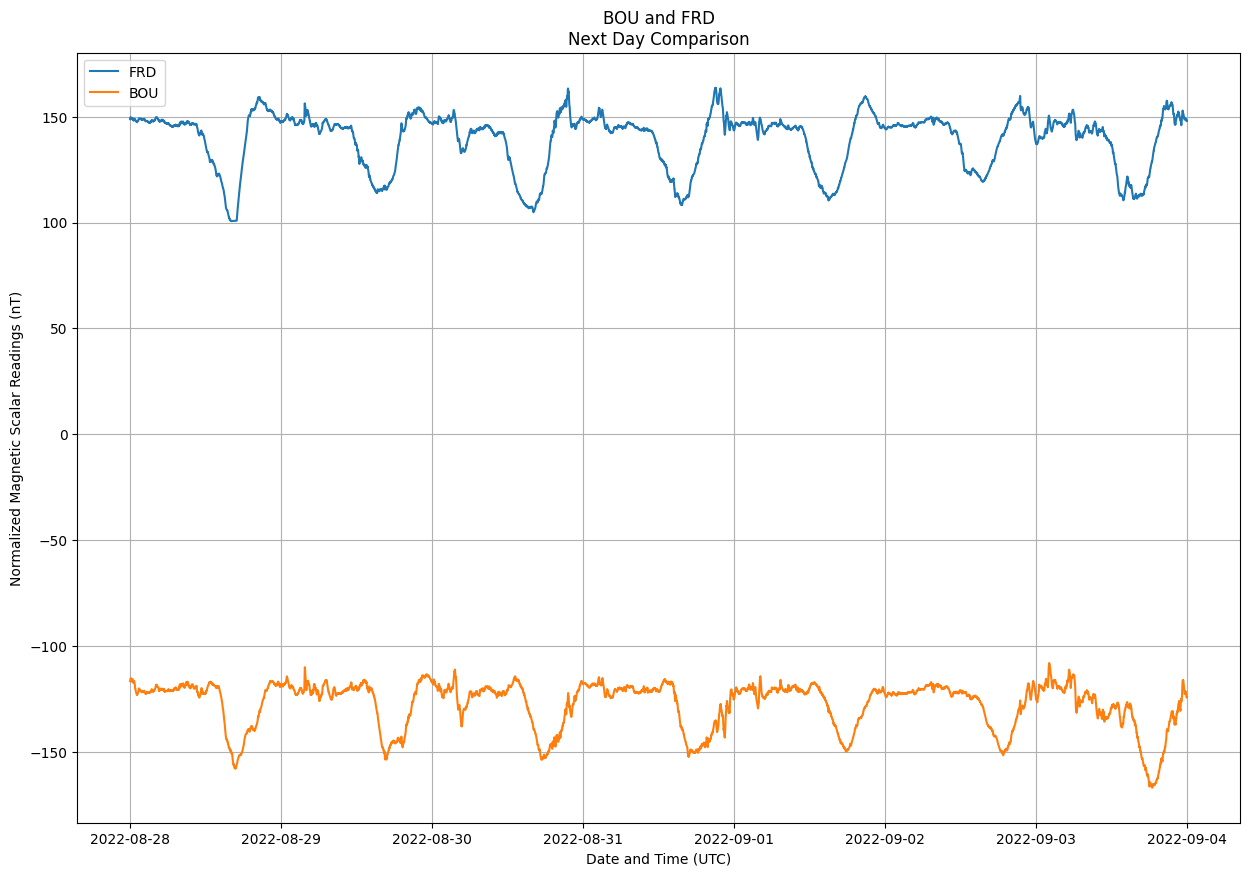

In [10]:
df_dict = pi.loadInterMagData(EXAM_DIR, second=False)

from_name = arguments['from_data'] # data from 'extended' station
to_name   = arguments['to_data'] # data at location to estimate

from_df = df_dict[from_name]
to_df_pred   = df_dict[to_name]

to_df_pred = pu.reject_outliers(to_df_pred,
                           window_size=2000,
                           std_lim=3)

to_IGRF_f   = np.array(to_df_pred.IGRF_F)[0]
from_IGRF_f = np.array(from_df.IGRF_F)[0]

to_f   = np.array(to_df_pred.F)
from_f = np.array(from_df.F)
    
to_f_no_core_pred   = np.array(to_df_pred.F) - to_IGRF_f
from_f_no_core = np.array(from_df.F) - from_IGRF_f
    
to_t   = np.array(to_df_pred.epoch_sec)
from_t = np.array(from_df.epoch_sec)


plt.figure()
plt.title(from_name + ' and ' + to_name + '\nNext Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df_pred.datetime, to_f_no_core_pred, label=to_name)
plt.plot(from_df.datetime, from_f_no_core, label=from_name)
plt.legend()
plt.grid()


from_combined_t_pred, from_combined_f, _, _ , _ = Diurnal.longitude_norm(from_df, to_df.LONG.mean(), second=False)
from_combined_f_no_core_pred = from_combined_f - from_IGRF_f


interp_combined = interpolate.interp1d(from_combined_t_pred, from_combined_f_no_core_pred, 'cubic')

interp_mask_pred = np.logical_and(to_t >= from_combined_t_pred.min(), to_t <= from_combined_t_pred.max())
interp_t_pred    = to_t[interp_mask_pred] # Clip interpolation times

from_combined_interp_pred = interp_combined(interp_t_pred)

print([offset, scale])
from_combined_opt_f_pred = Diurnal.apply_cal([offset, scale], from_combined_f_no_core_pred)

# Create Neural Net Prediction Data Set: 
test_loader, test_ds, Xts, yts = neural_net.process_testing_data(interp_t_pred, from_combined_interp_pred, to_f_no_core_pred[interp_mask_pred])

# Training Neural Net

In [11]:
# TODO Run Training Code: 
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch import sqrt

lr = 5e-1
num_epoch = 1500 # Change this later 


loss_hist = []
val_rmse_hist = []

# TODO
# opt = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()



for model in [neural_net]:
    opt = optim.AdamW(model.parameters(), lr=lr) # Create optimizer with selected learning rate
    scheduler = ExponentialLR(opt, gamma=0.99)
    
    a_tr_loss = []
    a_tr_rmse = []
    a_ts_loss = []
    a_ts_rmse = []

    for epoch in range(num_epoch):
        model.train() # Model is set in training mode
        sum_rmse = 0 # initialize correct counter
        total = 0 # initialize total counter

        batch_loss_tr = [] # Array to store loss for each batch
        for train_iter, data in enumerate(train_loader):
            x_batch,y_batch = data # separate input and outputs
            #y_batch = y_batch.type(torch.long) 
            out = model(x_batch)

            loss = criterion(out,y_batch) #criterion for predicted vs truth
            batch_loss_tr.append(loss.item()) # Add Loss to batch loss


            # Compute gradients using back propagation
            opt.zero_grad() # Sets all gradients to 0
            loss.backward() # Apply backwards propogation to calculate gradient

            # Take an optimization 'step'
            opt.step()
            sum_rmse += loss.item()*y_batch.size()[0]
            total += y_batch.size()[0]

        a_tr_loss.extend(batch_loss_tr) # Add batch losses to a_tr_loss
        a_tr_rmse.append(np.sqrt(sum_rmse/total)) # Add Average RMSE Over Epoch
    
        if epoch >= 50:
            scheduler.step()
        
        model.eval() # put model in evaluation mode

        sum_rmse = 0 # Reset correct number counter
        total = 0 # Reset total counter

        batch_loss_ts = []
        with torch.no_grad():
            # Why is test set not calculated all at once - why do we use a for loop? 
            for data in test_loader:
                Xts_nn, yts_nn = data # Separate test data
                #yts_nn = yts_nn.type(torch.long) 
                outputs = model(Xts_nn) #Get predictions

                test_loss = criterion(outputs,yts_nn).item()
                batch_loss_ts.append(test_loss) #Get loss of predictions

                sum_rmse += loss.item()*yts_nn.size()[0]
                total += yts_nn.size()[0]

        a_ts_loss.append(np.mean(batch_loss_ts)) # Is average of losses = loss if test_set was done all at once
        a_ts_rmse.append(np.sqrt(sum_rmse/total)) # Calculate accuracy for fold
        
        if(epoch%10==0):
            print('Epoch {0:d}: RMSE {1:.4f}'.format(epoch, np.sqrt(sum_rmse/total)))
        
    loss_hist.append(a_tr_loss)
    val_rmse_hist.append(a_ts_rmse)


Epoch 0: RMSE 76.6600
Epoch 10: RMSE 5.7265
Epoch 20: RMSE 4.5764
Epoch 30: RMSE 4.4818
Epoch 40: RMSE 4.9066
Epoch 50: RMSE 4.5101
Epoch 60: RMSE 4.3000
Epoch 70: RMSE 4.5340
Epoch 80: RMSE 4.4475
Epoch 90: RMSE 4.3595
Epoch 100: RMSE 4.6502
Epoch 110: RMSE 3.8973
Epoch 120: RMSE 4.4041
Epoch 130: RMSE 4.1242
Epoch 140: RMSE 4.1307
Epoch 150: RMSE 3.7686
Epoch 160: RMSE 4.0278
Epoch 170: RMSE 3.9211
Epoch 180: RMSE 4.0434
Epoch 190: RMSE 3.8535
Epoch 200: RMSE 3.6629
Epoch 210: RMSE 3.5956
Epoch 220: RMSE 3.5314
Epoch 230: RMSE 3.4426
Epoch 240: RMSE 3.5012
Epoch 250: RMSE 3.9413
Epoch 260: RMSE 3.6718
Epoch 270: RMSE 3.4380
Epoch 280: RMSE 3.5034
Epoch 290: RMSE 3.4728
Epoch 300: RMSE 3.3781
Epoch 310: RMSE 3.5601
Epoch 320: RMSE 3.4649
Epoch 330: RMSE 3.5635
Epoch 340: RMSE 3.3919
Epoch 350: RMSE 3.3691
Epoch 360: RMSE 3.3660
Epoch 370: RMSE 3.2544
Epoch 380: RMSE 3.2643
Epoch 390: RMSE 3.2862
Epoch 400: RMSE 3.1258
Epoch 410: RMSE 3.2851
Epoch 420: RMSE 3.6270
Epoch 430: RMSE 3.228

# Model Performance over Epoch

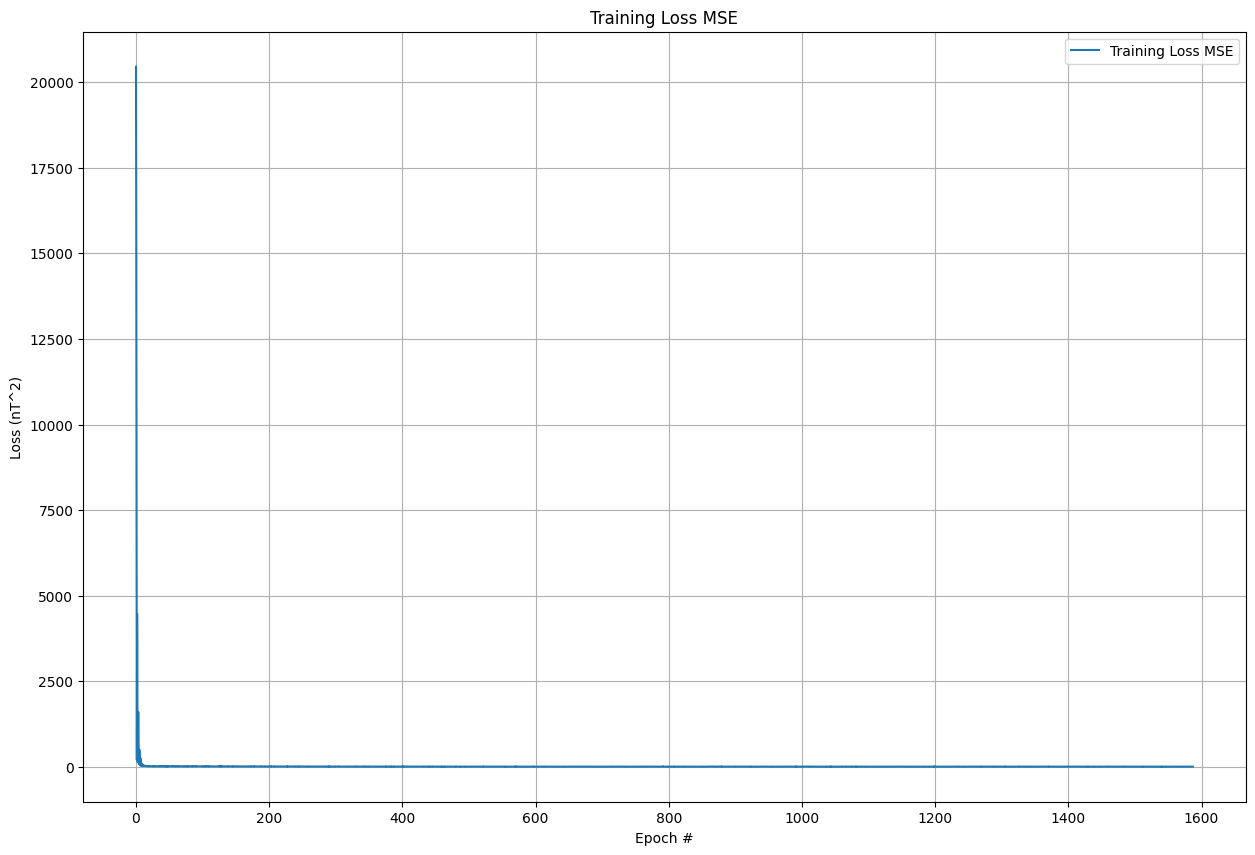

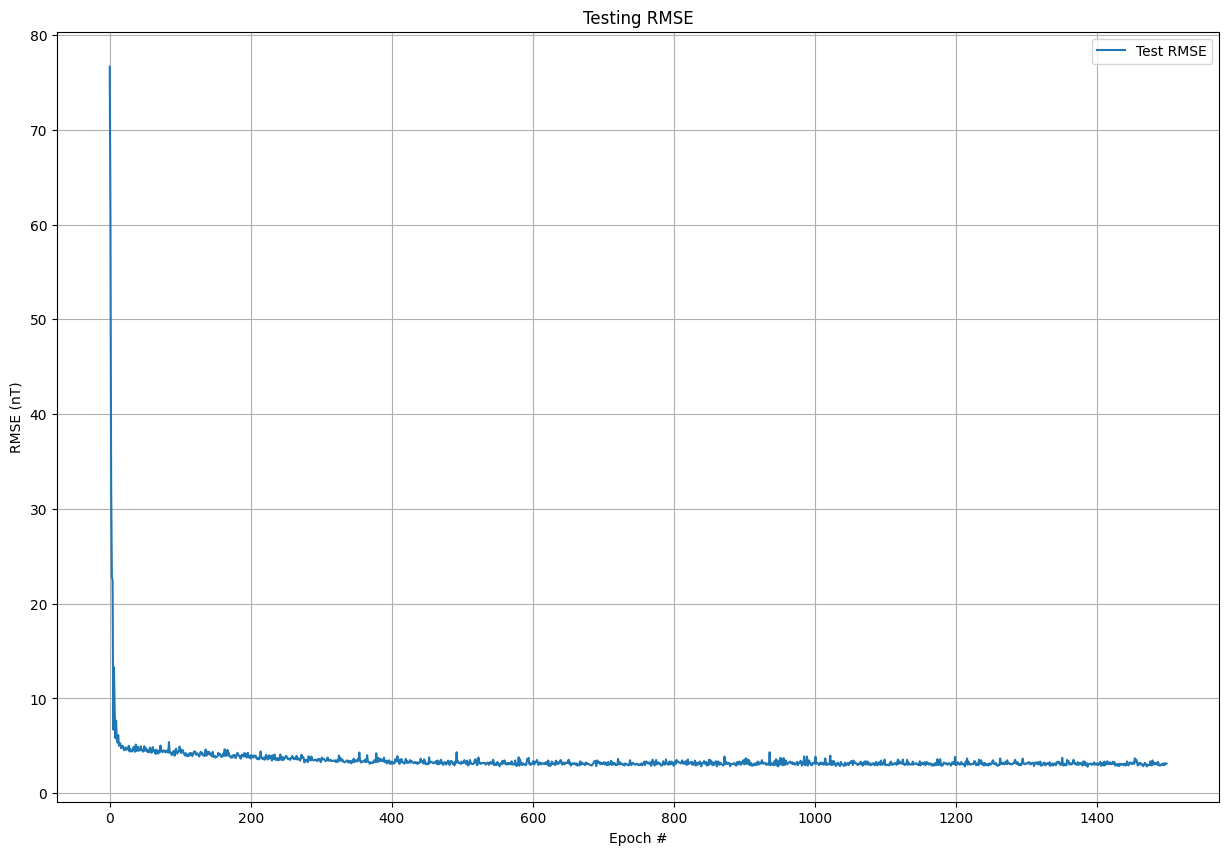

In [12]:

num_batch = len(loss_hist[0])
epoch = np.arange(num_batch)*batch_size/len(train_loader.dataset)

plt.figure()
plt.plot(epoch,loss_hist[0],label = 'Training Loss MSE')
plt.legend()
plt.xlabel('Epoch #')
plt.ylabel('Loss (nT^2)')
plt.title('Training Loss MSE')
plt.grid()

epoch = range(num_epoch)
plt.figure()
plt.plot(epoch,val_rmse_hist[0],label = 'Test RMSE')
plt.title('Testing RMSE')
plt.xlabel('Epoch #')
plt.ylabel('RMSE (nT)')
plt.grid()
plt.legend()

# Comparison (Training)

(14234,) (14234,)
(14234,) (14234,)
(14234,) (14234,)
(14234,) (14234,)
(14234,) (14234,)
(14234,) (14234,)
RMSE linear: 7.986347836223282
RMSE knn: 6.0394555011496465
RMSE linear: [8.790711662764958, 4.935904905364423, 7.782201207822115, 8.41776179247429, 6.051182395010509, 8.725218536920682, 5.051074247169201, 6.504824126508706, 13.770645352006357, 5.661645642387581]
RMSE knn: [3.71705672025808, 3.4968403158925043, 14.703316956594314, 4.098884982645321, 3.9461423741316506, 4.799753879285396, 3.906575665781908, 3.275180341228011, 5.895098263992511, 3.5688616308583443]
RMSE linear Kp [<4, >=4]: [7.750461203048675, 9.625783414346374]
RMSE knn: Kp [<4, >=4] [6.235449349490681, 4.214484002553829]


1

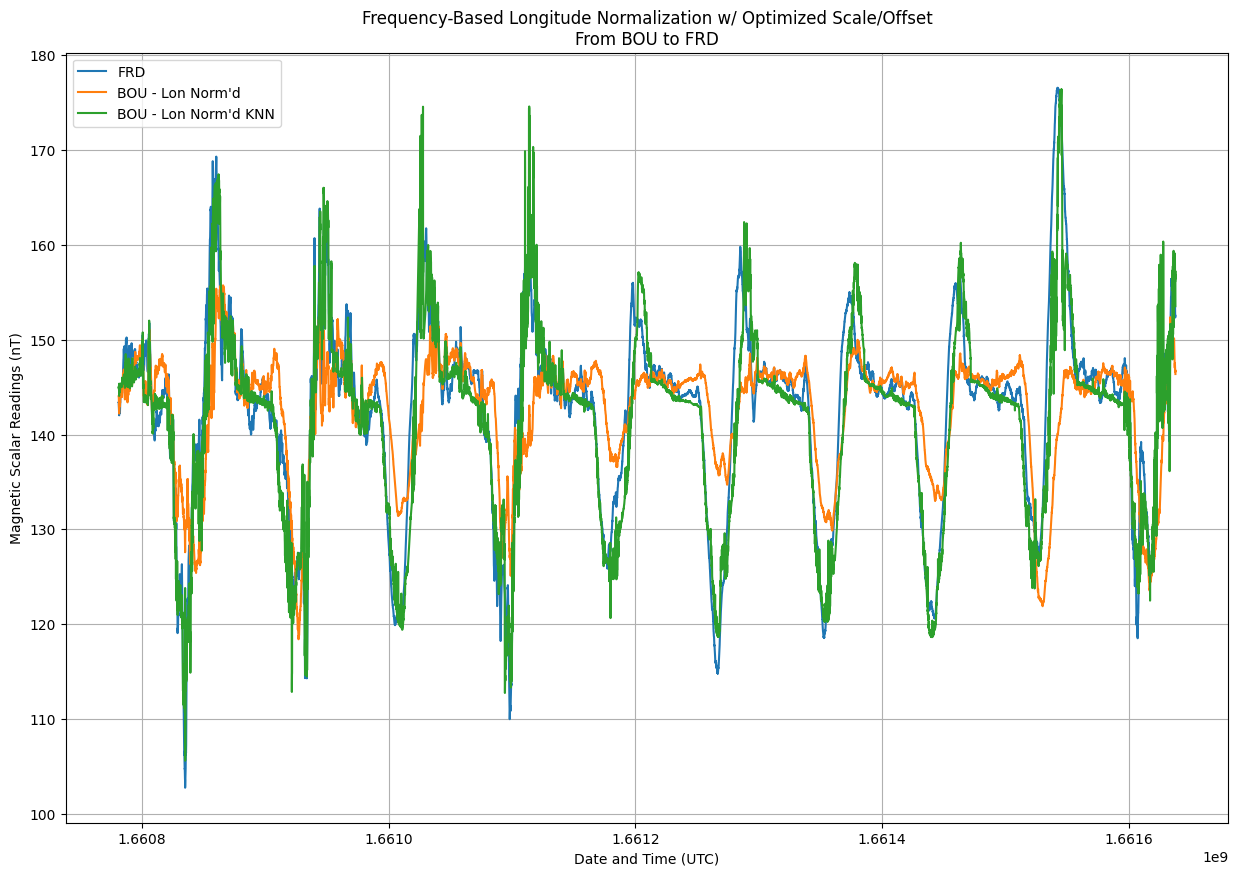

In [13]:

original_data = neural_net.x_tensor(from_combined_t, from_combined_f_no_core)
with torch.no_grad():
    prediction = np.hstack(neural_net(original_data).numpy()).tolist()
 # TODODODO_______________________________________-----------------------------------

plt.figure()
plt.title('Frequency-Based Longitude Normalization w/ Optimized Scale/Offset\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec[interp_mask], to_f_no_core[interp_mask], label=to_name)
plt.plot(from_combined_t, from_combined_opt_f, label='{} - Lon Norm\'d'.format(from_name))
plt.plot(from_combined_t, prediction, label='{} - Lon Norm\'d KNN'.format(from_name))
plt.legend()
plt.grid()



# Calculate Root Mean Square Error
rmse_linear= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f)
rmse_knn= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction)

rmse_linear_broken= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f,'day')
rmse_knn_broken= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction,'day')

rmse_kp_linear = different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f,'Kp')
rmse_kp_knn = different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction,'Kp')

print('RMSE linear:', rmse_linear)
print('RMSE knn:', rmse_knn)

print('RMSE linear:', rmse_linear_broken)
print('RMSE knn:', rmse_knn_broken)

print('RMSE linear Kp [<4, >=4]:', rmse_kp_linear)
print('RMSE knn: Kp [<4, >=4]', rmse_kp_knn)


first_data_list = [from_name, to_name, start_tra, end_tra, offset, scale, rmse_linear, rmse_knn]
first_data_list.extend(rmse_linear_broken)
first_data_list.extend(rmse_knn_broken)
first_data_list.extend(rmse_kp_linear)
first_data_list.extend(rmse_kp_knn)
out_file.write(','.join(map(str,first_data_list)))
out_file.write(',')


# Comparison (Prediction)

# Test Optimal Parameters for Next Day's Data

(9968,) (9968,)
(9968,) (9968,)
RMSE linear: 8.535169316218086
RMSE knn: 7.997296157142161
(9968,) (9968,)
(9968,) (9968,)
(9968,) (9968,)
(9968,) (9968,)
RMSE linear: [7.477369002900749, 6.503756237360933, 11.067354299016118, 9.287648094905554, 9.08083329713649, 7.318984638896389, 8.11618041278296]
RMSE knn: [7.297401734109852, 5.896862852138033, 10.714142509644569, 7.874504531304948, 6.274577916361312, 5.628445706978427, 10.80163071761366]
RMSE linear Kp [<4, >=4]: [8.535294227800456, 8.533264599014922]
RMSE knn: Kp [<4, >=4] [7.979577138312323, 8.262748090328278]


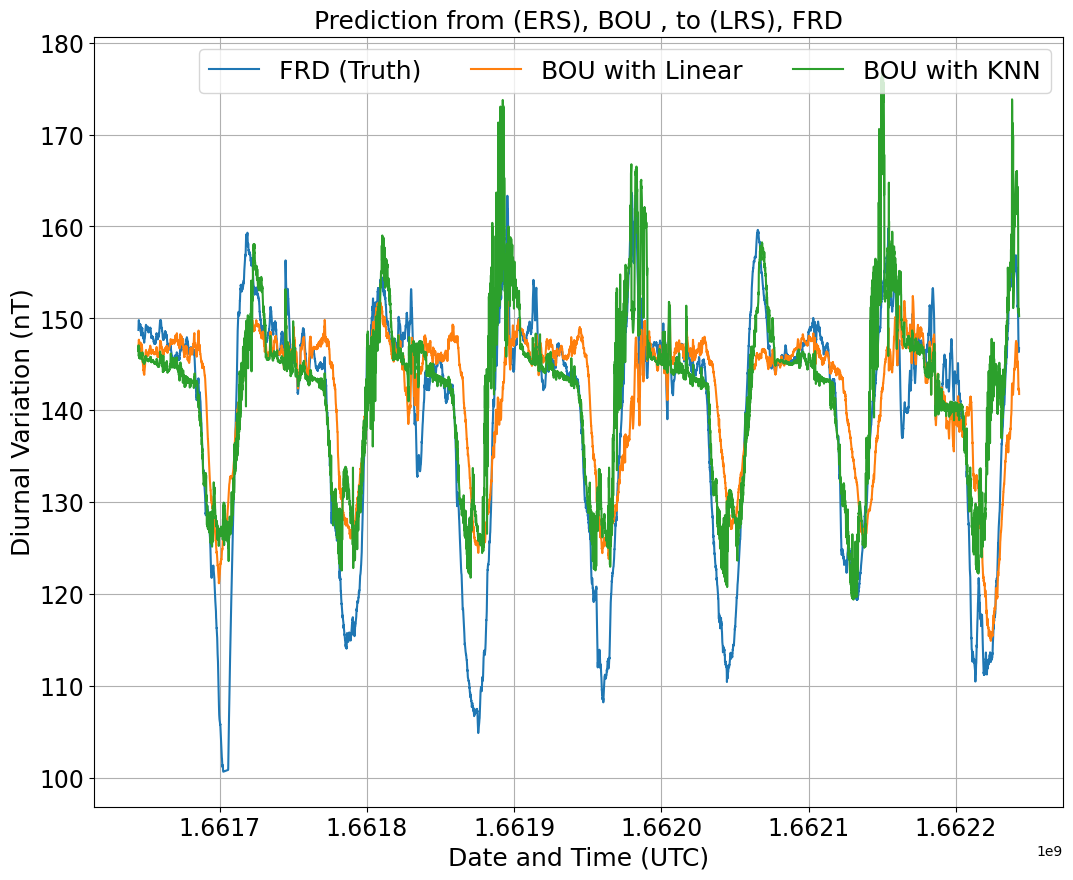

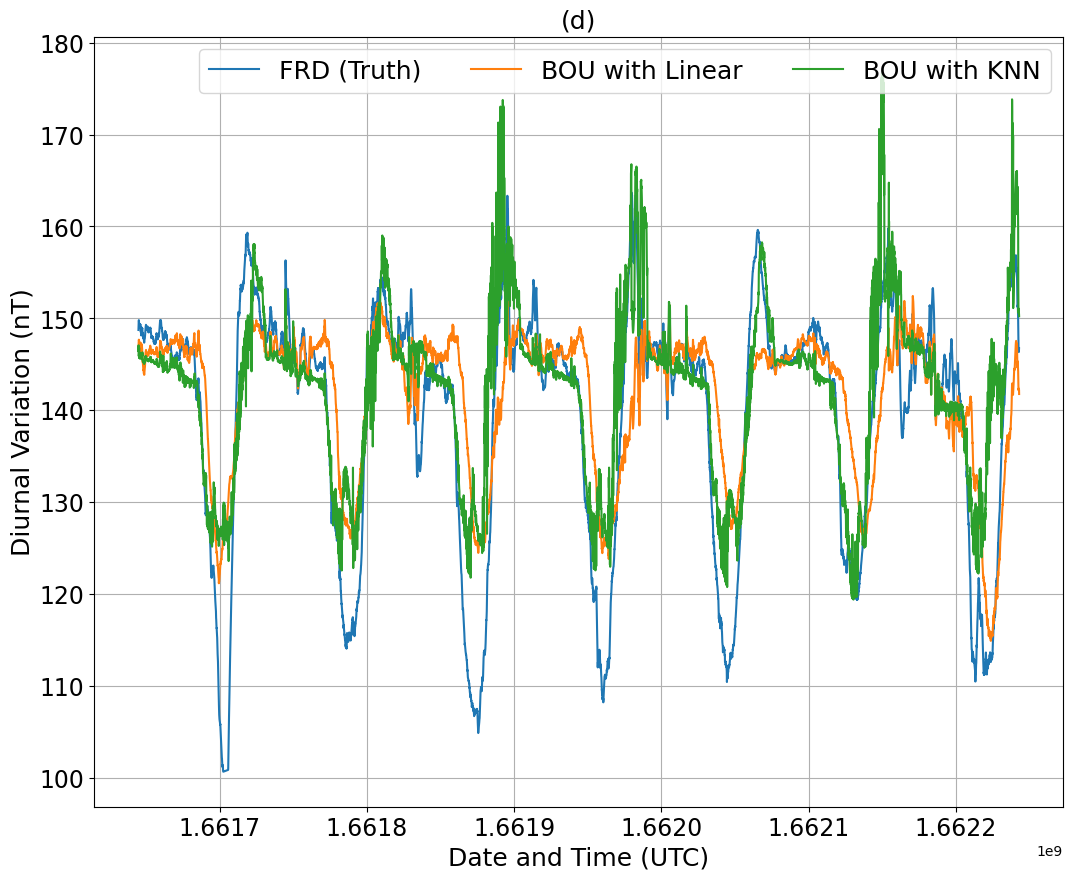

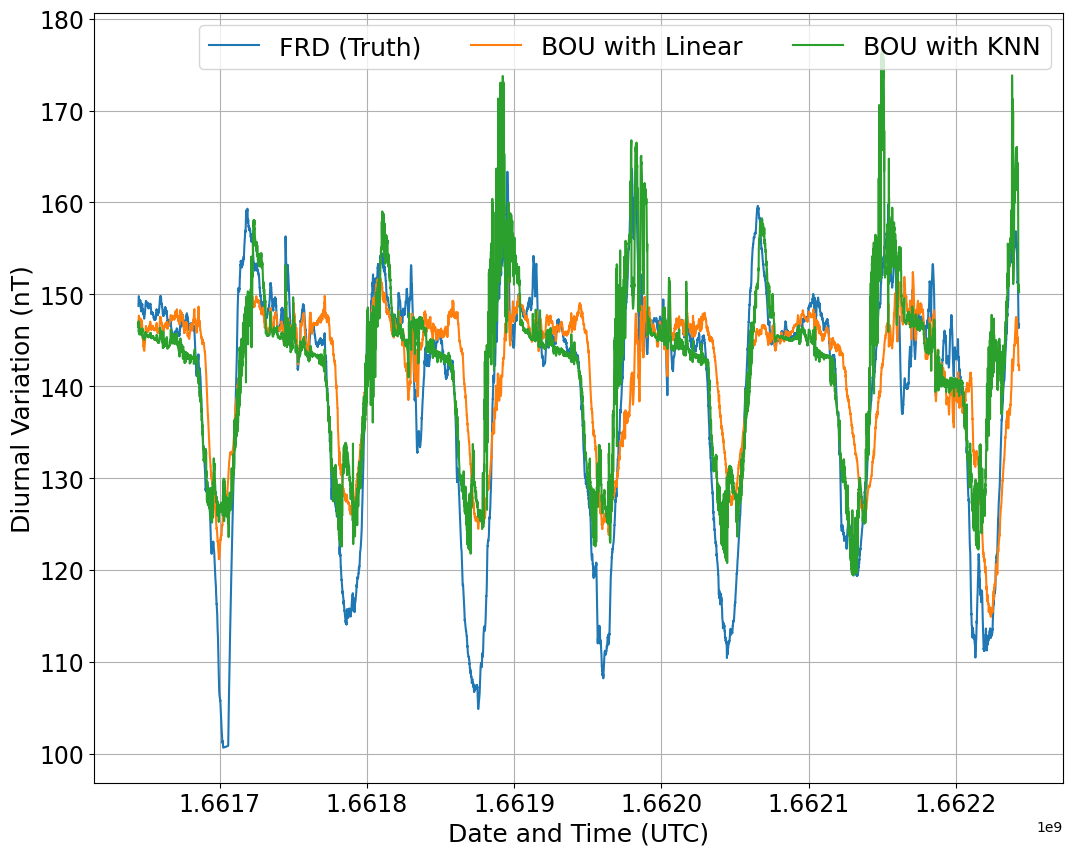

In [14]:
pred_data = neural_net.x_tensor(from_combined_t_pred, from_combined_f_no_core_pred)
with torch.no_grad():
    prediction_pred = np.hstack(neural_net(pred_data).numpy()).tolist()
font = 18
plt.figure(figsize = (12.5,10))
plt.title('Prediction from (ERS), ' + from_name  +  ' , to (LRS), ' + to_name, fontsize = font)
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df_pred.epoch_sec[interp_mask_pred], to_f_no_core_pred[interp_mask_pred], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t_pred, from_combined_opt_f_pred, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t_pred, prediction_pred, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol=3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

plt.figure(figsize = (12.5,10))
plt.title('(d)', fontsize = font)
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df_pred.epoch_sec[interp_mask_pred], to_f_no_core_pred[interp_mask_pred], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t_pred, from_combined_opt_f_pred, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t_pred, prediction_pred, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol = 3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

plt.figure(figsize = (12.5,10))
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df_pred.epoch_sec[interp_mask_pred], to_f_no_core_pred[interp_mask_pred], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t_pred, from_combined_opt_f_pred, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t_pred, prediction_pred, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol = 3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

# Calculate Root Mean Square Error
next_rmse_linear= different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,from_combined_opt_f_pred)
next_rmse_knn= different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,prediction_pred)

print('RMSE linear:', next_rmse_linear)
print('RMSE knn:', next_rmse_knn)


next_rmse_linear_broken = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,from_combined_opt_f_pred, 'day')
next_rmse_knn_broken = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,prediction_pred, 'day')

next_rmse_kp_linear = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,from_combined_opt_f_pred, 'Kp')
next_rmse_kp_knn = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,prediction_pred, 'Kp')

print('RMSE linear:', next_rmse_linear_broken)
print('RMSE knn:', next_rmse_knn_broken)

print('RMSE linear Kp [<4, >=4]:', next_rmse_kp_linear)
print('RMSE knn: Kp [<4, >=4]', next_rmse_kp_knn)

second_data_list = [start_tst, end_tst, next_rmse_linear, next_rmse_knn]
second_data_list.extend(next_rmse_linear_broken)
second_data_list.extend(next_rmse_knn_broken)
second_data_list.extend(next_rmse_kp_linear)
second_data_list.extend(next_rmse_kp_knn)
out_file.write(','.join(map(str,second_data_list)))
out_file.write('\n')
out_file.close()